In [1]:
##### import fiona
from shapely.geometry import *
# from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

# import contextily as cx
# import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
# from matplotlib import colors
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

#### Functions

In [3]:
def readNHD(index):
    '''
    This function takes the index for an NHD HUC4 basin (see
    ./data/HUC4_lookup_no_great_lakes_PIXC.csv), reads it in,
    forces the geometry to 2D, and returns the basin dataframe.
    '''
    
    ## Set-up
    mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
    prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/' # _with_waterbody

    # Define dtypes for lookup tables to preserve leading zeros
    dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
    # Read in HUC lookup table
    lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

    # Get current HUC2 and HUC4 IDs
    huc2 = 'HUC2_' + lookup.loc[index,'HUC4'][0:2]
    huc4 = 'NHDPLUS_H_' + lookup.loc[index,'HUC4'] + '_HU4_GDB'
    
    # Set data filepath
    file_path = os.path.join(prep_path, huc2, huc4 + '_prepped.gpkg') # _with_waterbody

    ## Read in prepped NHD flowlines
    features = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'Bin', 'geometry']
    basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')
    
    # Make geometry 2D LineStrings
    basin['geometry'] = basin.geometry.explode().force_2d()
    
    return basin, huc4

In [4]:
def cut(line, distance):
    '''
    This function takes one reach centerline and 1/10th of the reach length
    and cuts the lie in two at the distance from its starting point. It then
    returns the trimmed piece and the remainder of the reach centerline.
    '''
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [5]:
def bitwiseMask(ds):
    '''
    This function masks a PIXC granules: for now, it ony remove pixels
    with land classification and those with bad geolocation_qual.
    # See page 65 of PIXC PDD: https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information&sections=about%2Bdata
    '''
    mask = np.where(np.logical_and(ds.classification > 1, ds.geolocation_qual < 2**12))[0]
    # print(mask.shape)
    return mask

In [6]:
def makeGDF(ds, mask, data_var):
    '''
    This function takes the pixel cloud xarray object, makes a masked
    GeoDataFrame, renames columns as needed, set the CRS, reprojects
    the CRS, and returns a GeoDataFrame.
    '''

    # Create GDF
    gdf_PIXC = gpd.GeoDataFrame(ds[data_var][mask],
                                geometry=gpd.points_from_xy(
                                    ds.longitude[mask],
                                    ds.latitude[mask]),
                                crs="EPSG:4326") # PIXC has no native CRS, setting same as River_SP

    if data_var == 'classification':
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)
    else:
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: data_var}, inplace=True)
    
    # Convert the crs to WGS 84 / Pseudo-Mercator
    gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)
    
    return gdf_PIXC

In [7]:
def segmentReach(reach):
    '''
    Ths function takes a reach center line, cuts it into ten segments of
    equal length, and returns those ten segments.
    '''
    # Get linestring
    line = reach.geometry
    # Find length of segments
    dist = line.length/10
    
    # Make empty list for segments
    segments = []

    # Segment the reach
    for i in range(9):
        try:
            # Chop the reach, store remainder
            new, line = cut(line=line, distance=dist)
            # Append new segment to GeoSeries of all segments
            segments.append(new)
            # segments[i]: new
        except:
            print(reach['NHDPlusID'])
    
    # Append final segment to list
    segments.append(line)

    return segments

In [8]:
def getCoverage(reach, basin_crs, gdf_PIXC):
    '''
    Ths function takes a segmented reach, explodes it to get one row
    per reach, buffers the reach segments with 1/2 the calculated width
    on either of the reach segment centerlines, intersects the buffered
    segments with the SWOT PIXC, and calculates the percent coverage for
    the whole reach, and returns this proportion.
    
    Right now, a segment only needs to have one pixel in it to be
    considered "detected".
    '''
    
    # Make GeoSeries with just segments
    segments = gpd.GeoSeries(data=reach['segments'], crs=basin_crs)

    # Buffer segments by 1/2 the calculated width
    # CITE BEIGER
    segments = segments.buffer(distance=(reach.WidthM/2),cap_style='flat')
    
    # Make GeoDataFrame of segments
    segments = gpd.GeoDataFrame(geometry=segments)
    
    # Get pixels in reach
    inside = gpd.sjoin(gdf_PIXC, segments, how='inner',
                       predicate='within').rename(columns={'index_right': 'segment'})

    if inside.empty:
        prop = 0
    else:    
        # Get number of pixels in each reach segment
        counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
        # Calculate coverage (proportion of reaches with >= 1 pixel in them)
        prop = len(counts.loc[counts['count'] != 0])/10
    return prop

#### Read in and prep NHD

In [9]:
# Set slurm job index
i = 4 # HUC4 0108, Connecticut
# i = 109 # HUC4 1711, Snoqualmie
# i = 57 # HUC4 0807, Mississippi
# i = 191 # HUC4 1708, Columbia

In [10]:
# Read prepped NHD
basin, huc4 = readNHD(index=i)

In [11]:
basin

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
0,"(0, 10]",None,0.36,10000900074595.00,2.50,"LINESTRING (-8132916.01 5289901.543, -8132916...."
1,"(0, 10]",None,0.60,10000900043332.00,1.54,"LINESTRING (-8061020.932 5374240.653, -8061022..."
2,"(0, 10]",None,0.21,10000900077596.00,1.29,"LINESTRING (-8087730.068 5179341.463, -8087730..."
3,"(0, 10]",None,0.11,10000900087485.00,2.67,"LINESTRING (-8121499.756 5322310.966, -8121501..."
4,"(50, 60]",Ammonoosuc River,1.88,10000900022936.00,50.93,"LINESTRING (-8008860.725 5493474.985, -8008861..."
...,...,...,...,...,...,...
64749,"(0, 10]",Legate Hill Brook,1.14,10000900038209.00,3.63,"LINESTRING (-8116396.119 5262446.77, -8116368...."
64750,"(0, 10]",Middle Branch Indian Stream,0.89,10000900012117.00,2.50,"LINESTRING (-7935262.401 5668274.395, -7935271..."
64751,"(0, 10]",None,2.66,10000900024205.00,2.98,"LINESTRING (-7951969.936 5527770.608, -7951985..."
64752,"(0, 10]",None,1.60,10000900011942.00,2.46,"LINESTRING (-7945927.353 5522423.902, -7945917..."


In [12]:
huc4

'NHDPLUS_H_0108_HU4_GDB'

In [13]:
np.max(basin['WidthM'])

np.float64(219.80273587283008)

#### Read in and prep PIXC

In [21]:
pixc_path = '../data/small_rivers/mar_2024_ver_c/leaf_off/SWOT_L2_HR_PIXC_014_341_229R_20240429T152954_20240429T153005_PIC0_01.nc'
# pixc_path = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_011_345_239R_20240227T044209_20240227T044220_PIC0_01.nc'

In [22]:
tile_name = pixc_path[-71:-3]
tile_name

'SWOT_L2_HR_PIXC_014_341_229R_20240429T152954_20240429T153005_PIC0_01'

In [23]:
# Read in xarray
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group='pixel_cloud', engine='h5netcdf')

In [24]:
# Make dict for legend labels
flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
codes = {idx:k for idx, k in enumerate(flags, start=1)}

In [38]:
# counts = pd.DataFrame(ds_PIXC.geolocation_qual).value_counts().sort_index()
# counts

In [33]:
variables = ['azimuth_index', 'range_index']
xarr = ds_PIXC[variables]

In [28]:
xarr

<xarray.Dataset> Size: 211MB
Dimensions:        (points: 6609347)
Coordinates:
    latitude       (points) float64 53MB dask.array<chunksize=(508412,), meta=np.ndarray>
    longitude      (points) float64 53MB dask.array<chunksize=(508412,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    azimuth_index  (points) float64 53MB dask.array<chunksize=(944193,), meta=np.ndarray>
    range_index    (points) float64 53MB dask.array<chunksize=(944193,), meta=np.ndarray>
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3271
    interferogram_size_range:    4726
    looks_to_efflooks:           1.5470152426164074
    num_azimuth_looks:           7.0
    azimuth_offset:              5

In [44]:
df = xarr.to_dataframe().reset_index()

In [45]:
df

,points,azimuth_index,range_index,latitude,longitude
0,0,161.00,417.00,42.09,-72.91
1,1,161.00,418.00,42.09,-72.92
2,2,161.00,419.00,42.09,-72.91
3,3,161.00,420.00,42.09,-72.91
4,4,161.00,421.00,42.09,-72.90
...,...,...,...,...,...
6609342,6609342,3109.00,4586.00,42.50,-71.92
6609343,6609343,3109.00,4587.00,42.50,-71.93
6609344,6609344,3109.00,4588.00,42.50,-71.92
6609345,6609345,3109.00,4589.00,42.50,-71.93


In [46]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude,
                                         df.latitude))

In [36]:
gdf

,azimuth_index,range_index,geometry
0,161.00,417.00,POINT (-72.91433 42.09377)
1,161.00,418.00,POINT (-72.91575 42.09403)
2,161.00,419.00,POINT (-72.91021 42.09302)
3,161.00,420.00,POINT (-72.90537 42.09213)
4,161.00,421.00,POINT (-72.90276 42.09166)
...,...,...,...
6609342,3109.00,4586.00,POINT (-71.92198 42.50176)
6609343,3109.00,4587.00,POINT (-71.92951 42.5032)
6609344,3109.00,4588.00,POINT (-71.92131 42.50163)
6609345,3109.00,4589.00,POINT (-71.92691 42.5027)


In [39]:
# Make mask
mask = bitwiseMask(ds=ds_PIXC)

# # If dataframe not empty after filtering
# if mask.shape != (0,):
#     # Make PIXC
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_var='classification')
    # # Append to list
    # d.append(gdf_PIXC)

#### Get bounds of PIXC and crop basin to it

In [40]:
# # Get bounds of PIXC, construct polygon
# This was giving a box oriented NS, EW
# bounds_PIXC = gdf_PIXC.total_bounds
# poly = box(bounds_PIXC[0], bounds_PIXC[1], bounds_PIXC[2], bounds_PIXC[3])

In [41]:
# basin_crop = basin.clip(poly)

In [42]:
bounds_PIXC = gdf_PIXC.union_all().convex_hull

In [43]:
basin_crop = basin.clip(bounds_PIXC)

In [44]:
# FOR NOW: Drop reaches with MultiLineString type
# This occurs because some reaches flow out of and then back
# into the PIXC tile of interest.
basin_crop = basin_crop[basin_crop.geometry.geometry.type=='LineString']

In [45]:
# Order of all possible bins for plotting
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]', '(200, 500]', '(500, 1000]']

In [46]:
# Find width bins present in cropped hydrography
bins = list(np.unique(basin_crop.Bin))
bins

['(0, 10]',
 '(10, 20]',
 '(150, 200]',
 '(20, 30]',
 '(200, 500]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]']

In [47]:
# Make sorted list of bins present
ordered = []
for binn in order:
    if binn in bins:
        ordered.append(binn)
ordered

['(0, 10]',
 '(10, 20]',
 '(20, 30]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]',
 '(150, 200]',
 '(200, 500]']

#### Segment reach, calculates coverage functions

In [48]:
# Segment the reaches
basin_crop['segments'] = basin_crop.apply(func=segmentReach, axis=1)

In [54]:
# Get the coverage for each reach (at least one pixel/segment)
basin_crop['coverage'] = basin_crop.apply(func=getCoverage, args=(basin_crop.crs, gdf_PIXC), axis=1)

In [55]:
print(pd.DataFrame(basin_crop.coverage.value_counts().reset_index().sort_index()))

    coverage  count
0       0.00   5243
1       0.10    980
2       0.20    371
3       0.30    186
4       1.00    167
5       0.40    112
6       0.50     80
7       0.60     64
8       0.90     52
9       0.80     43
10      0.70     37


In [56]:
mean_cov = basin_crop.groupby('Bin')['coverage'].mean()

In [57]:
print(mean_cov)

Bin
(0, 10]      0.03
(10, 20]     0.16
(150, 200]   0.94
(20, 30]     0.40
(200, 500]   0.98
(30, 40]     0.49
(40, 50]     0.65
(50, 60]     0.43
(60, 70]     0.76
Name: coverage, dtype: float64


Text(0, 0.5, 'Percent Detected')

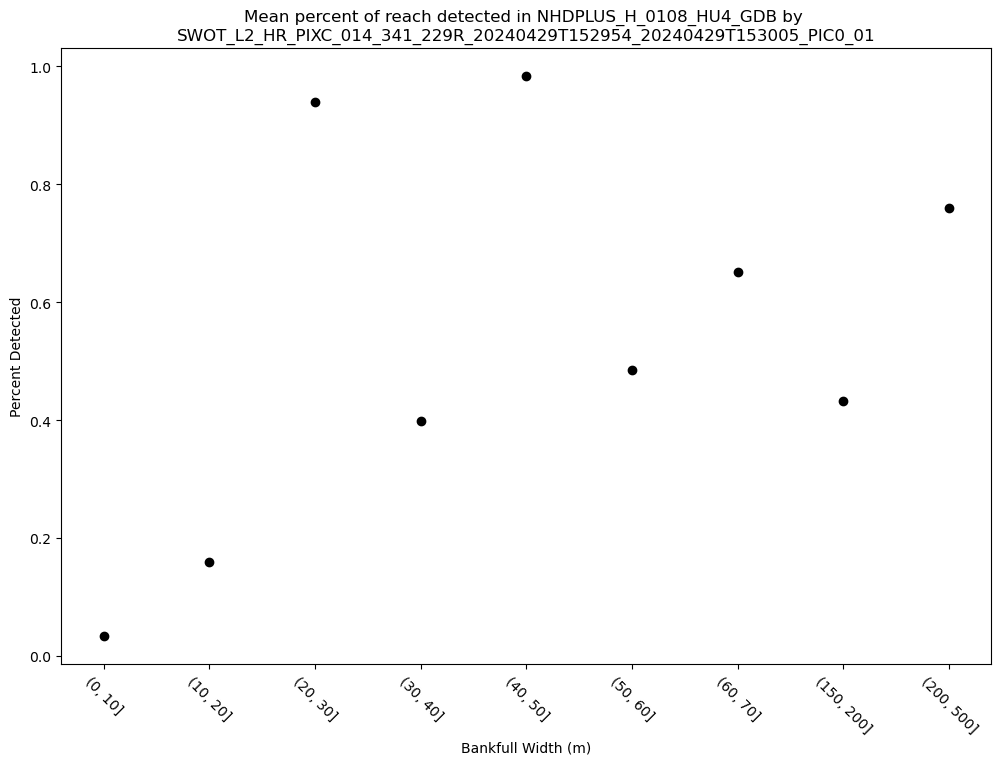

In [58]:
# plt.scatter(x=ordered, y=coverage, c='k')
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x=mean_cov.keys(), y=mean_cov.values, c='k')
plt.title('Mean percent of reach detected in ' + huc4 +' by \n'
          + tile_name)
plt.xticks(rotation=-45);

# Set number of ticks for x-axis
ax.set_xticks(range(len(ordered)))
# Set ticks labels for x-axis
ax.set_xticklabels(ordered)

plt.xlabel('Bankfull Width (m)')
plt.ylabel('Percent Detected')
# plt.savefig(fname='./figures_for_unit_test/one_tile_'+ huc4 +'.png', bbox_inches='tight')

In [67]:
outpath = './figures_for_unit_test/'

In [68]:
# Make color palette
# palette = {2: 'darkolivegreen', 3: 'slateblue', 4: 'steelblue', 5: 'hotpink',
#            6: 'saddlebrown', 7: 'darkslategray'}
palette = {2: 'darkkhaki', 3: 'cornflowerblue', 4: 'blue', 5: 'hotpink',
           6: 'lightsalmon', 7: 'lightblue'}

In [69]:
pwd

'/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC'

In [ ]:
# Plot the full set of reaches
# Get labels for plot
nums = list(np.unique(gdf_PIXC.klass).astype('int'))
labels = [codes[x] for x in nums]

# Make cmap
cmap = colors.ListedColormap([palette[x] for x in nums])

# Plot
fig, ax = plt.subplots(figsize=(15,15))

basin_crop.plot(color='w', alpha=0.2, ax=ax)
gdf_PIXC.plot(column=gdf_PIXC.klass, categorical=True, 
            markersize=10, cmap=cmap, legend=True,
            legend_kwds={'labels': labels,
                         'framealpha': 1, 
                         'title_fontsize': 'medium',
                         'loc': 'upper left'},
            ax=ax)
# bounds.plot(color='r', marker="s", markersize=50, ax=ax)

# Basemap
cx.add_basemap(ax, crs=gdf_PIXC.crs, source=cx.providers.CartoDB.DarkMatter, alpha=0.9)

# 
leg = ax.get_legend()
leg.set_title("Class")          
ax.title.set_text('PIXC granule ' + tile_name + ' intersected with ' + huc4)
plt.savefig(fname = outpath + huc4 + '_' + tile_name +  '_masked.png', bbox_inches='tight')

**PLOT ONE SEGMENTED REACH**

In [74]:
basin_crop[basin_crop['GNIS_Name'] == 'Tolt River']

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry,segments,coverage
192170,"(20, 30]",Tolt River,1.47,55000800244963.00,25.14,"LINESTRING (-13569323.01 6047553.943, -1356936...",[LINESTRING (-13569323.009701123 6047553.94277...,0.90
214740,"(20, 30]",Tolt River,1.26,55000800282287.00,25.39,"LINESTRING (-13571076.985 6046774.261, -135712...",[LINESTRING (-13571076.985091293 6046774.26051...,1.00
153594,"(20, 30]",Tolt River,0.06,55000800206994.00,25.39,"LINESTRING (-13572823.58 6047211.297, -1357289...",[LINESTRING (-13572823.579929402 6047211.29675...,0.40
87432,"(20, 30]",Tolt River,0.66,55000800018552.00,25.09,"LINESTRING (-13568476.404 6047574.905, -135685...",[LINESTRING (-13568476.403664665 6047574.90507...,0.70
149462,"(20, 30]",Tolt River,0.55,55000800207882.00,25.04,"LINESTRING (-13567761.549 6047847.296, -135677...",[LINESTRING (-13567761.548544178 6047847.29579...,0.90
53827,"(20, 30]",Tolt River,0.41,55000800094333.00,24.96,"LINESTRING (-13567611.848 6048378.442, -135676...",[LINESTRING (-13567611.84778491 6048378.441663...,0.80
158876,"(20, 30]",Tolt River,1.86,55000800208349.00,24.65,"LINESTRING (-13565774.354 6052203.762, -135657...",[LINESTRING (-13565774.354199572 6052203.76187...,0.90
81409,"(20, 30]",Tolt River,0.86,55000800056433.00,24.83,"LINESTRING (-13566736.131 6049323.015, -135668...",[LINESTRING (-13566736.130641134 6049323.01509...,0.40
88995,"(20, 30]",Tolt River,0.39,55000800019041.00,24.80,"LINESTRING (-13566951.075 6049761.009, -135669...",[LINESTRING (-13566951.074777083 6049761.00877...,0.60
195395,"(20, 30]",Tolt River,0.34,55000800245897.00,24.73,"LINESTRING (-13566968.472 6050268.517, -135669...",[LINESTRING (-13566968.471741933 6050268.51682...,0.30


In [122]:
one = data=basin_crop.loc[192170]

In [ ]:
one = gpd.GeoDataFrame(one, geometry=geometrygeometry)

In [120]:
one.geometry

<bound method DataFrame.transpose of                                                       192170
Bin                                                 (20, 30]
GNIS_Name                                         Tolt River
LengthKM                                                1.47
NHDPlusID                                  55000800244963.00
WidthM                                                 25.14
geometry   LINESTRING (-13569323.009701123 6047553.942775...
segments   [LINESTRING (-13569323.009701123 6047553.94277...
coverage                                                0.90>

In [103]:
one = one.buffer(distance=(basin_crop.loc[192170].WidthM/2))

AttributeError: 'Series' object has no attribute 'buffer'

In [105]:
# Get pixels in reach
inside = gpd.sjoin(gdf_PIXC, one, how='inner',
                   predicate='within').rename(columns={'index_right': 'segment'})

ValueError: 'right_df' should be GeoDataFrame, got <class 'geopandas.geoseries.GeoSeries'>

KeyboardInterrupt: 

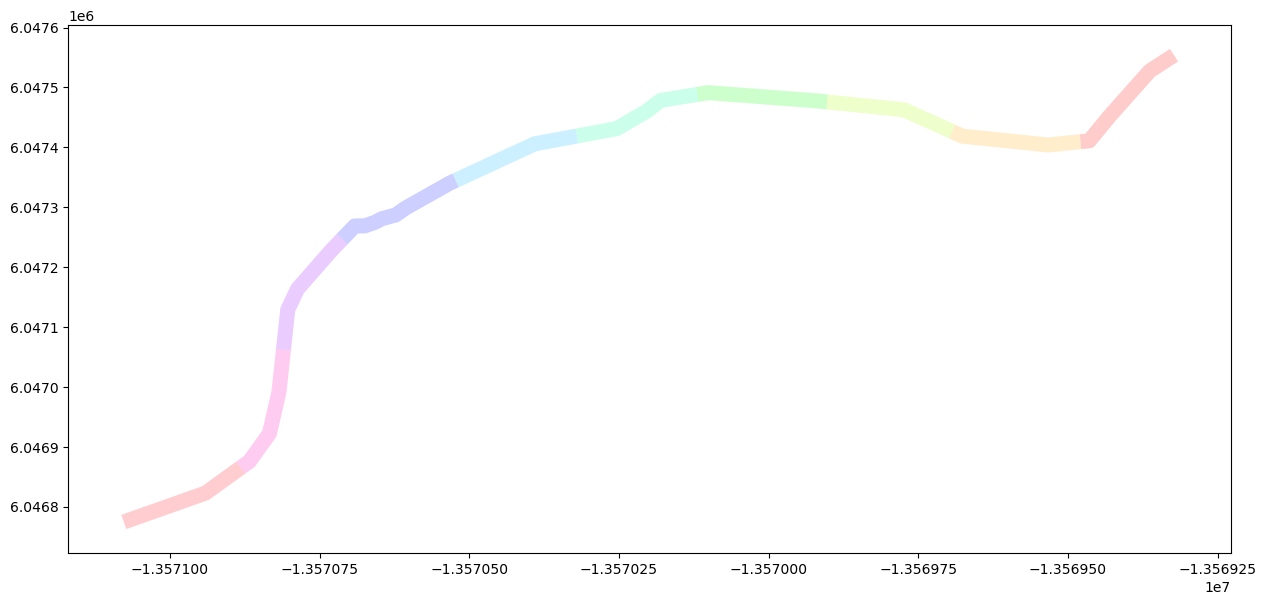

In [94]:



# Plot the full set of reaches
# Get labels for plot
nums = list(np.unique(gdf_PIXC.klass).astype('int'))
labels = [codes[x] for x in nums]

# Make cmap
cmap = colors.ListedColormap([palette[x] for x in nums])

# Plot
fig, ax = plt.subplots(figsize=(15,15))
one.buffer(distance=(basin_crop.loc[192170].WidthM/2),
           cap_style='flat').plot('hsv', alpha=0.2, ax=ax)
# basin_crop.plot(color='w', alpha=0.2, ax=ax)
gdf_PIXC[gdf].plot(column=gdf_PIXC.klass, categorical=True, 
            markersize=10, cmap=cmap, legend=True,
            legend_kwds={'labels': labels,
                         'framealpha': 1, 
                         'title_fontsize': 'medium',
                         'loc': 'upper left'},
            ax=ax)
# bounds.plot(color='r', marker="s", markersize=50, ax=ax)

# Basemap
cx.add_basemap(ax, crs=gdf_PIXC.crs, source=cx.providers.CartoDB.DarkMatter, alpha=0.9)

# 
leg = ax.get_legend()
leg.set_title("Class")          
# ax.title.set_text('PIXC granule ' + tile_name + ' intersected with ' + huc4)
# plt.savefig(fname = outpath + huc4 + '_' + tile_name +  '_masked.png', bbox_inches='tight')